# Stability, poles, and zeros


$$
\require{color}\notag%
$$

In [3]:
%run ../setup.ipynb

Most of the filters we've encountered so far have been *stable*, in the sense that if an input signal $x[n]$ has bounded values, so too will the output $y[n]$.

As an example of an unstable system, consider

```{math}
:label: doubling

y[n] = x[n] + 2\cdot y[n-1].
```

Plugging $x[n] = [1, 0, 0, 0, \dots]$ into this definition produces the impulse response
```{math}
\begin{align*}
y[0] &= x[0] + 2\cdot 0 &= 1\\
y[1] &= x[1] + 2\cdot y[0] &= 2\\
y[2] &= x[2] + 2\cdot y[1] &= 4\\
&\dots\\
y[n] &= 2^n
\end{align*}
```
which grows exponentially and without bound.  This system is **unstable**!

While it is relatively straightforward to determine that {eq}`doubling` is unstable, it is not always so easy.
This leads us to the question: how can we determine in general whether a given system is stable?

## Transfer functions and polynomials

Recall that for a linear IIR filter with feed-forward coefficients $b[k]$ and feed-back coefficients $a[k]$, the transfer function is given by the ratio of the z-transform of sequences $b[k]$ and $a[k]$:

```{math}
H(z) = \frac{B(z)}{A(z)} = \frac{\displaystyle\sum_{k=0}^{K-1} b[k] \cdot z^{-k}}{\displaystyle\sum_{k=0}^{K-1} a[k] \cdot z^{-k}}.
```

````{margin} Polynomials

You may remember polynomials from an algebra class in the distant past.
For example, solving quadratic forms like the following

```{math}
2x^2 - x - 1 = 0
```
either by factoring or by using the quadratic formula.

Quadratics are a special case of polynomials where the largest *degree* is 2.
The polynomials that come up in signal processing are usually of much larger degree (given by the order of the filter), and we'll generally be using the computer to find the roots automatically.
````
More specifically, $H(z)$ is the result of dividing two **polynomials** $B(z)$ and $A(z)$:
```{math}
\begin{align*}
B(z) &= b[0] \cdot z^0 + b[1] \cdot z^{-1} + b[2] \cdot z^{-2} + \dots + b[K-1] \cdot z^{-K+1}\\
A(z) &= a[0] \cdot z^0 + a[1] \cdot z^{-1} + a[2] \cdot z^{-2} + \dots + a[K-1] \cdot z^{-K+1}.
\end{align*}
```
Strictly speaking, these are polynomials in $z^{-1}$ (since the powers have negative exponents instead of positive exponents), but the distinction is unimportant for our purposes.

It turns out that we can learn quite a bit about a filter's behavior by examining the properties of these polynomials, and specifically, finding their **roots** by solving $B(z) = 0$ and $A(z) = 0$.

### Roots and algebra

From the [fundamental theorem of algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra), we have that any polynomial 
```{math}
Q(z) = \sum_{d=0}^{D} q[d] \cdot z^d
```
has $D$ (complex) roots, that is, solutions to the equation $Q(z) = 0$.

For example, the polynomial $2x^2 - x - 1$ has roots $x=1$ and $x=-1/2$.
These roots can be found by factoring the polynomial:
```{math}
2x^2 - x - 1 = (2x + 1) \cdot (x - 1)
```
and then setting each factor to 0 independently (since either being 0 is sufficient to ensure the product is 0):
```{math}
\begin{align*}
2x+1 = 0 &\Rightarrow x = -\frac{1}{2}\\
x-1 = 0 &\Rightarrow x = 1\\
\end{align*}
```

As a second example, consider
```{math}
x^2 - 6x + 9 = 0.
```
This also is a degree-2 polynomial, so it should have two solutions.
However, if we factor the polynomial, it turns out that the solutions are not unique:
```{math}
x^2 - 6x + 9 = (x-3)\cdot(x-3).
```
In this case, we say that there is one solution $x=3$ *of multiplicity 2* (because it occurs twice).

**The fundamental theorem of algebra does not require that all solutions be unique!**

As a final example, take
```{math}
x^3 + 1 = 0
```
or equivalently, $x^3 = -1$.
In this case, there is only one *real-valued* solution ($x=-1$), but there are two more *complex-valued* solutions: $x = e^{\mathrm{j}\cdot \pi / 3}$ and $x = e^{-\mathrm{j}\cdot \pi / 3}$.

**The fundamental theorem of algebra allows for roots to be complex.**

## Zeros
 
For the moment, let's focus on the numerator of the transfer function, i.e., the polynomial $B(z)$ derived from the feed-forward coefficients.
By definition, if $z_0$ is a root of $B(z)$, then $B(z_0) = 0$.
As long as $z_0$ is not also a root of $A(z)$, we will have

```{math}
H(z_0) = \frac{B(z_0)}{A(z_0)} = \frac{0}{A(z_0)} = 0.
```

The location in the complex plane of the zeros (roots of $B(z)$) tells us about which frequencies are attenuated by the filter.
This is because polynomials are *continuous*: if $B(z_0) = 0$, then other values of $z$ near $z_0$ will be small ($B(z) \approx 0$).

Before going further, it may be helpful to visualize what we're talking about.
To make things concrete, we'll analyze a Type-2 Chebyshev filter constructed by the following code block:
```{code-block} python
fs = 8000  # Sampling rate
fc = 1000  # Cutoff frequency
fstop = 1500 # Stop-band 1KHz above cutoff
attenuation = 80  # we'll require 80 dB attenuation in the stop band
ripple = 6  # we'll allow 6 dB ripple in the passband

# Compute the order for this filter, which in this case is 9
order, wn = scipy.signal.cheb2ord(fc, fstop, ripple, attenuation, fs=fs)
b, a = scipy.signal.cheby2(order, attenuation, wn, fs=fs)
```

Once we have the filter coefficients `b` and `a`, we can obtain the zeros of the filter by the following code:
```{code-block} python
zeros, _, _ = scipy.signal.tf2zpk(b, a)
```
The function `tf2zpk` takes in a transfer function (represented by `b` and `a`) and returns the zeros (z), poles (p), and gain (k) of the filter.
We'll come back to poles and gain later on, so for now we'll retain just the zeros.

If we print the zeros, we'll see a sequence of 9 complex numbers:
```
array([ 0.38141995-0.92440187j,  0.26658886-0.96381034j,
       -0.02490664-0.99968978j, -0.57559933-0.81773187j,
       -0.57559933+0.81773187j, -0.02490664+0.99968978j,
        0.26658886+0.96381034j,  0.38141995+0.92440187j,
       -1.        +0.j        ])
```
We can then plot these values in the complex plane, and compare them to the frequency response of the filter (generated by `freqz` as in the previous section).

In [280]:
fs = 8000  # Sampling rate
fc = 1000  # Cutoff frequency
fstop = 1500
attenuation = 80  # we'll require 80 dB attenuation in the stop band
ripple = 6  # we'll allow 6 dB ripple in the passband

order_ell, wn = scipy.signal.cheb2ord(fc, fstop, ripple, attenuation, fs=fs)
zeros, poles, gain = scipy.signal.cheby2(order_ell, attenuation, wn, fs=fs, output='zpk')

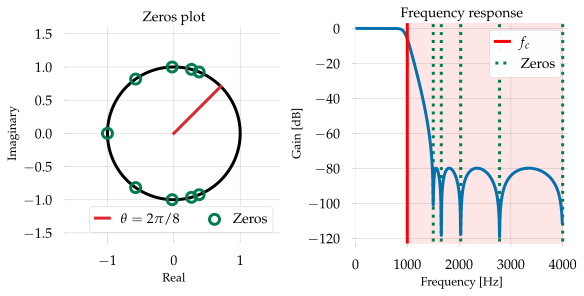

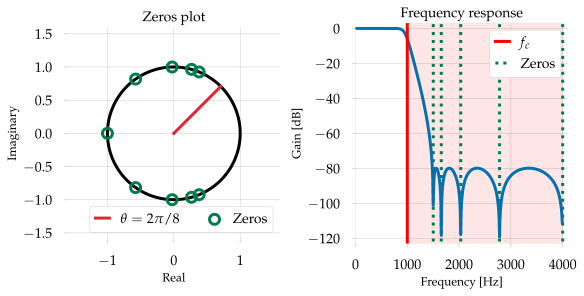

In [232]:
fig, (ax, ax1) = plt.subplots(figsize=figaspect(0.5), ncols=2)

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-10)

ax.add_patch(circ)
ax.set(xlim=[-1.6, 1.6], ylim=[-1.6, 1.6], aspect='equal', xlabel='Real', ylabel='Imaginary')

ax.scatter(zeros.real, zeros.imag, marker='o', s=100, edgecolor=colors[5], color=None, facecolor='none', linewidth=3, label='Zeros')
ax.plot([0, np.cos(2 * np.pi / 8)], [0, np.sin(2 * np.pi / 8)], color=colors[1], label=r'$\theta = 2\pi / 8$')
ax.legend(loc='lower right', ncol=2)
ax.set(title='Zeros plot')

freq, H = scipy.signal.freqz_zpk(zeros, poles, gain, fs=fs)
ax1.plot(freq, 20 * np.log10(np.abs(H) + 1e-6))
ax1.axvline(fc, color='r', label='$f_c$')
ax1.vlines(np.angle(zeros) * fs / (2 * np.pi), -140, 10, colors=colors[5], linestyle=':', label='Zeros')
ax1.set(xlim=[0, fs/2 + 100], ylim=[-123, 3])
ax1.axvspan(fc, fs/2, alpha=0.1, color='r')
ax1.set(xlabel='Frequency [Hz]', ylabel='Gain [dB]')
ax1.set(title='Frequency response')
ax1.legend(loc='upper right')
glue('zerosplot', fig)

```{glue:figure} zerosplot
---
name: zerosplot
---

**Left**: The zeros of an order-9 Type-2 Chebyshev filter with cutoff frequency $f_c = 1000$, sampling rate $f_s=8000$, transition bandwidth of 500 Hz, passband ripple of 3dB, and stop-band attenuation of 80dB.
The angle $\theta = 2\pi / 8$ corresponds to the cutoff frequency divided by the sampling rate $f_c / f_s = 1000 / 8000$.
All zeros of this filter have unit magnitude, and come in conjugate pairs: 4 with positive imaginary component, 4 with negative, and one with zero (at Nyquist).
**Right**: The frequency response curve of this filter.  Each zero in the left plot corresponds to a particular frequency, which coincide with the minima of the frequency response curve as indicated by the dashed lines.
```

From {numref}`zerosplot`, we can observe that the minima in the frequency response curve line up exactly with the zeros of the transfer function.
More generally, frequencies *near* the zeros are also attenuated!
You can think of the zeros as physical weights that drag down the frequency response.

This is only part of the story though: we'll also need to look at the feedback coefficients to get the full picture.

## Poles

So far, we've found that the zeros of $B(z)$ can tell us about the frequency response of a filter.  But what about the zeros of $A(z)$?

The roots of $A(z)$ are known as **poles** of the filter, and are denoted by $p_0, p_1, \dots, p_{K-1}$.
For any pole $p$ (that is not also a root of $B(z)$), $H(p) = B(p) / A(p)$ would divide by zero, which is a very bad thing indeed!
Without getting too far into the technical details, it is possible to make sense of this division by looking at the behavior of $H(z)$ in a neighborhood around a pole.

The intuition behind the name "pole" derives from the idea of the function $|H(z)|$ (the magnitude of $H(z)$) can be thought of as a sheet draped over the complex plane, which is held up by (tent) poles.
A simplified illustration of this is provided below in {numref}`asymptote`.

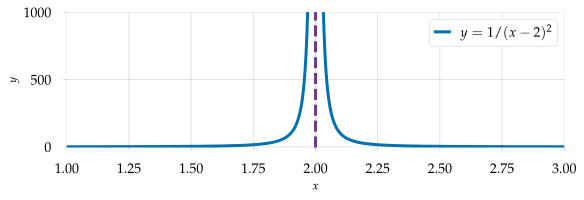

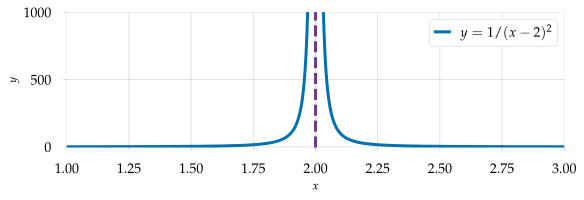

In [281]:
fig, ax = plt.subplots(figsize=(figaspect(1./3)))

x = np.linspace(1, 3, num=500)
y = 1./(x-2)**2

ax.plot(x, y, label=r'$y = 1/(x-2)^2$')
ax.axvline(2, color=colors[4], linestyle='--')
ax.set(xlabel='$x$', ylabel='$y$', ylim=[-5, 1e3])
ax.legend(loc='upper right')
glue('asymptote', fig);

```{glue:figure} asymptote
:name: asymptote

The function $y = \frac{1}{(x-2)^2}$ has a pole at $x=2$.
As $x$ approaches 2 from either direction, $y$ increases.
```

If the zeros of $H$ tell us where frequencies are attenuated, the poles tell us where frequencies are amplified.
(This is a bit of a simplification, as both poles and zeros can affect both gain and attenuation, but let's go with it for now.)

Continuing our previous example, we'll use the `tf2zpk` function to compute the zeros *and* poles for our filter:
```{margin} Gain

The feedback coefficient $a[0]$ is known as the *gain* of the system, as it is used to scale up (or down) the output $y[n]$.
As we have noted before, there is some ambiguity in IIR filter design, as we can always divide the remaining coefficients by $a[0]$ without changing the behavior of the system.

This is why defining just the zeros and poles of a system isn't quite enough to fully determine the coefficients.
To reconcile this ambiguity, most implementations for zero and pole calculation (e.g., `tf2zpk`) will return the gain ($a[0]$) as a separate return value.
```

```{code-block} python
zeros, poles, gain = scipy.signal.tf2zpk(b, a)
```
Again, this will produce an array of 9 complex numbers for `poles`:
```
array([0.6640386 -0.61973512j, 0.54573487-0.49475044j,
       0.44310112-0.35506889j, 0.36783278-0.18847207j,
       0.3394446 +0.j        , 0.36783278+0.18847207j,
       0.44310112+0.35506889j, 0.54573487+0.49475044j,
       0.6640386 +0.61973512j])
```
corresponding to the 9 roots of $A(z)$.
Like we did above with the zeros plot, we can visualize the position of the poles in the complex plane.
Typically, both the poles and zeros are illustrated in the same figure, which is helpfully known as a **pole-zero plot**.

```{margin} Plotting poles and zeros

Traditionally, poles are denoted by $\times$ (crosses), and zeros are denoted by $\circ$ (circles).
```

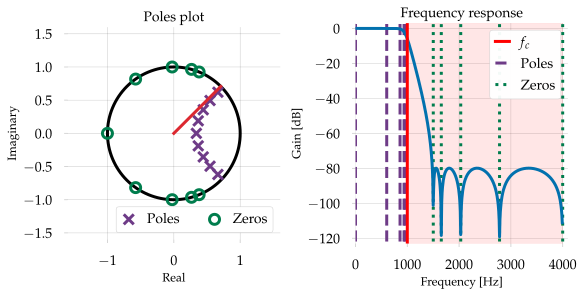

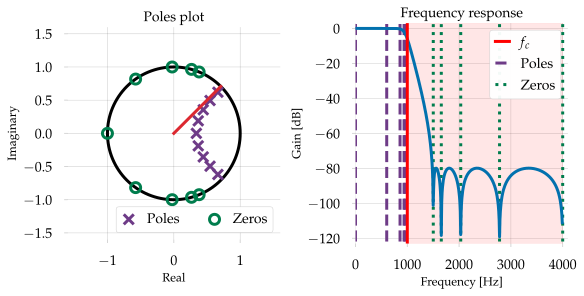

In [285]:
fig, (ax, ax1) = plt.subplots(figsize=figaspect(0.5), ncols=2)

circ = patches.Ellipse((0, 0), 2, 2, edgecolor='k', linewidth=3, fill=False, zorder=-10)

ax.add_patch(circ)
ax.set(xlim=[-1.6, 1.6], ylim=[-1.6, 1.6], aspect='equal', xlabel='Real', ylabel='Imaginary')

ax.scatter(poles.real, poles.imag, marker='x', s=100, color=colors[4], linewidth=3, label='Poles')
ax.scatter(zeros.real, zeros.imag, marker='o', s=100, edgecolor=colors[5], color=None, facecolor='none', linewidth=3, label='Zeros')
ax.plot([0, np.cos(2 * np.pi / 8)], [0, np.sin(2 * np.pi / 8)], color=colors[1])
ax.legend(loc='lower right', ncol=3)
ax.set(title='Poles plot')

freq, H = scipy.signal.freqz_zpk(zeros, poles, gain, fs=fs)
ax1.plot(freq, 20 * np.log10(np.abs(H) + 1e-6))
ax1.axvline(fc, color='r', label='$f_c$')
ax1.vlines(np.angle(poles) * fs / (2 * np.pi), -140, 10, colors=colors[4], linestyle='--', label='Poles')
ax1.vlines(np.angle(zeros) * fs / (2 * np.pi), -140, 10, colors=colors[5], linestyle=':', label='Zeros')
ax1.set(xlim=[0, fs/2 + 100], ylim=[-123, 3])
ax1.axvspan(fc, fs/2, alpha=0.1, color='r')
ax1.set(xlabel='Frequency [Hz]', ylabel='Gain [dB]')
ax1.set(title='Frequency response')
ax1.legend(loc='upper right')
glue('polezeroplot', fig)

```{glue:figure} polezeroplot
:name: polezero

**Left**: The poles ($\times$) and zeros ($\circ$) of the filter previously analyzed in {numref}`zeroplot`.
**Right**: the frequency response curve, now with both pole and zero angles (frequencies) marked.
Note that the poles of this system are not on the unit circle, which is why the frequency response curve does not spike upward to infinity at each pole.
```

Once you learn how to read pole-zero plots, they can be a great way to quickly understand the behavior of a system.
For example, in {numref}`polezero`, we have zeros at high frequencies (angles approaching $\pi$) and poles near low frequencies, so we can infer that this is a low-pass filter.
A high-pass filter would exhibit the reverse behavior, with poles at larger angles and zeros at smaller angles.

The fact that zeros land exactly on the unit circle tells us that some frequencies will be attenuated severely (practically to zero).

## Factored transfer functions

Once we have the zeros $z_k$ and poles $p_k$ of a system, these can be used to write down the transfer function $H(z)$ equivalently in a *factored* form:
```{math}
H(z) = \frac{\left(z - z_0\right)\cdot \left(z - z_1\right) \dots \left(z - z_{K-1}\right)}{\left(z - p_0\right)\cdot \left(z - p_1\right) \dots \left(z - p_{K-1}\right)}
```
While this doesn't change the definition of the filter --- it is just another way of writing the same transfer function --- this form does have some benefits.

First, it allows us to reason about high-order filters as a cascade of low-order filters:
```{math}
\begin{align*}
H(z) &= \left(\frac{z-z_0}{z-p_0} \right)\cdot \left( \frac{z-z_1}{z-p_1}\right) \dots \left( \frac{z-z_{K-1}}{z-p_{K-1}}\right)\\
&= H_0(z) \cdot H_1(z) \dots H_{K-1}(z).
\end{align*}
```
This observation is often used to simplify the implementation of IIR filters and improve numerical stability (without changing the filter's behavior).
Most commonly, this is done by the *second-order sections* (SOS) method, e.g.:
```{code-block} python
# Construct a filter using second-order sections instead of
# feed-forward / feed-back coefficients b and a
sos = scipy.signal.cheby2(order, attenuation, wn, fs=fs, output='sos')

# Instead of lfilter with b and a, use sosfilt
y = scipy.signal.sosfilt(sos, x)

# Or for bidirectional filtering:
y = scipy.signal.sosfiltfilt(sos, x)
```

```{margin} Canceling poles and zeros

Technically, if a point is both a pole and a zero, this produces a factor of 0/0 in the transfer function.
0/0 is usually a sign that something bad is happening!

However, in this specific case, it does work out.
If $p_k = z_\ell$, then $(1-z_k z^{-1}) / (1-p_k^{-1})$
```
Second, it provides a way to reason about the interactions between poles and zeros.
Notably, if we have a pole which is also a zero, that is, $p_k = z_\ell$, then both of their corresponding factors can be removed from the filter without changing its behavior!
Concretely, this means that if a pole and a zero coincide, then their effects cancel each other out.

## Stability

Let's return to our first example of an unstable system, $y[n] = x[n] + 2\cdot y[n-1]$.
This is *unstable* because the output can diverge when given an input signal with finite values, e.g., a unit impulse produces a sequence $y[n] = 2^n$ that grows without bound and never settles down.

In standard form, this system has coefficients
```{math}
\begin{align*}
b &= [1]\\
a &= [1, -2].
\end{align*}
```

The transfer function of this system is 
```{math}
H(z) = \frac{b[0] \cdot z^0}{a[0] \cdot z^0 + a[1] \cdot z^{-1}} = \frac{1}{1 - 2\cdot z^{-1}}
```
This system has no zeros (the numerator is degree 0).
It has one pole, which we can find by solving $1 - 2z^{-1} = 0$:
```{math}
1 - 2z^{-1} = 0 \quad \Rightarrow \frac{2}{z} = 1 \quad \Rightarrow z = 2.
```

Contrast this filter with the first IIR filter we encountered in the previous chapter, the *exponential moving average* {eq}`ema`:
```{math}
y[n] = \frac{1}{2}\cdot x[n] + \frac{1}{2} \cdot y[n-1],
```
which has coefficients $b = [1/2]$ and $a= [1, -1/2]$.
This filter also has no zeros, and one pole, but the pole is located at $z = 1/2$.
It turns out that the exponential moving average filter is *stable*: its output does not diverge for any input signal $x[n]$ with finite values.

*So what's different about these two examples?*

It turns out that the stability of a filter depends on the location of the poles, and specifically, on their *magnitude*.

```{admonition} IIR stability
:class: information

Let $H(z)$ denote the transfer function of a linear, IIR filter with zeros $z_0, z_1, \dots, z_{K-1}$ and poles $p_0, p_1, \dots, p_{K-1}$,
and assume that no pole is also a zero.

The filter is **stable** if **all** poles $p$ have magnitude $|p| < 1$.
Or, equivalently, if all poles lie within the unit circle in the complex plane.

The filter is **unstable** if **any** pole $p$ has magnitude $|p| > 1$.
```

This fact gives us a simple test for stability of a filter:

1. Compute the poles of the filter, e.g., by `scipy.signal.tf2zpk` or `scipy.signal.sos2zpk`.
2. Discard any poles which are also zeros.
3. Compute the magnitude of all remaining poles.
4. If any pole has magnitude larger than 1, the filter is unstable.

As a corollary to this observation, note that FIR filters have no poles (since $A(z)= a[0] = 1 \neq 0$).
Since they have no poles, they also have no poles with magnitude larger than 1.
This is how we can say that any FIR filter is stable!

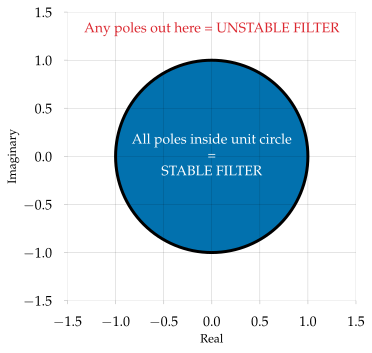

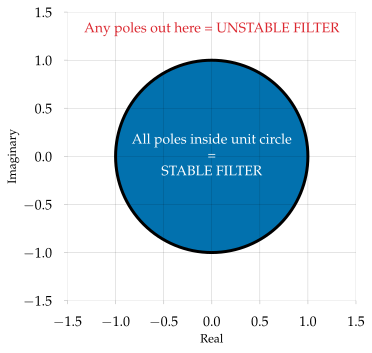

In [304]:
fig, ax = plt.subplots(figsize=figaspect(0.6))

circ = patches.Ellipse((0, 0), 2, 2, facecolor=colors[0], edgecolor='k', linewidth=3, fill=True, zorder=-10)

ax.add_patch(circ)
ax.text(0, 0, 'All poles inside unit circle\n = \nSTABLE FILTER', ha='center', va='center', color='w')
ax.text(0, 1.25, 'Any poles out here = UNSTABLE FILTER', ha='center', va='bottom', color=colors[1])
ax.set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], aspect='equal')
ax.set(xlabel='Real', ylabel='Imaginary')
glue('polestable', fig);

```{glue:figure} polestable
```

## Summary

In this section, we've seen how the z-transform allows us to reason about the behavior of a filter through its transfer function.
Specifically, we examined the polynomials $B(z)$ and $A(z)$ which make up the transfer function $H(z) = B(z) / A(z)$.
The roots of these polynomials determine when the transfer function goes to 0 (when $B(z) = 0$, the *zeros*) and when it diverges to infinity ($A(z) = 0$, the *poles*).
Finally, the location of the poles of a filter (inside or outside the unit circle) determines whether the filter is stable or unstable.